In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### The class is LinearSVM. Initializing an instance of the class with three hyper parameters learning rate, lambda and number of iterations. 

#### Fit method is used to train the linear SVM model using gradient descent optimization algorithm. It iterates over the data for a fixed number of iterations (n_iters). For each iteration, it calculates the loss based on the loss function and updates the weights (w) and bias (b) accordingly. 

#### Decision function is used to make the decisions for the trained SVM model. Calculates the dot product of the input features and the weight vector, subtracts the bias term.

#### Predict function predicts the class labels for the input data based on the sign of the output of the decision function. If the output is positive, it predicts one class otherwise, it predicts the other class.

In [18]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.l = []
        
    def fit(self, X, y):
        n_observations, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        y1 = np.where(y <= 0, -1, 1)   #### Using to convert class labels into binary levels
        
        for _ in range(self.n_iters):
            loss = 0
            for i, xi in enumerate(X):
                if (y1[i] * (np.dot(xi, self.w) - self.b) >= 1):
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(xi, y1[i]))
                    self.b -= self.lr * y1[i]
                    loss += 1 - y1[i] * (np.dot(xi, self.w) - self.b)
                    
            # Adding L2 (Ridge) regularization term to update weights
            
            self.w -= self.lr * self.lambda_param * self.w
            self.l.append(loss)

    def decision_fun(self, X):
        return np.dot(X, self.w) - self.b

    def predict(self, X):
        a = np.dot(X, self.w) - self.b
        return np.sign(a)

#### Function to predict using One-vs-Rest strategy takes a list of models and input data X and returns the predicted class labels and decision values.

In [19]:
def predict_ovr(models, X):
    decision_values = np.array([model.decision_fun(X) for model in models]).T
    predictions = np.argmax(decision_values, axis=1)
    return predictions, decision_values

In [20]:
# Load and prepare the dataset

iris = load_iris()
X = iris.data
y = iris.target

print('Dimension of X: ', X.shape)
print('Dimension of y: ', y.shape)

# For visualization purpose using pandas dataframe

x1 = pd.DataFrame(iris['data'], columns=iris['feature_names']) 
y1 = pd.DataFrame(iris['target'], columns=['species'])

df = pd.concat([x1, y1], axis=1)

print('\nTop 5 rows of the dataset:')
display(df.head(5))
print("\n Summary of the dataset:")
display(df.describe())

Dimension of X:  (150, 4)
Dimension of y:  (150,)

Top 5 rows of the dataset:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0



 Summary of the dataset:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


#### Splitting the dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Dimension of X_train: ', X_train.shape)
print('Dimension of X_test: ', X_test.shape)
print('Dimension of y_train: ', y_train.shape)
print('Dimension of y_test: ', y_test.shape)

Dimension of X_train:  (120, 4)
Dimension of X_test:  (30, 4)
Dimension of y_train:  (120,)
Dimension of y_test:  (30,)


In [23]:
# Scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training one SVM model per each class and evaluating

models = []
for i in range(len(np.unique(y))):
    y_train_ovr = np.where(y_train == i, 1, -1)
    svm_model = LinearSVM()
    svm_model.fit(X_train_scaled, y_train_ovr)
    models.append(svm_model)

# Make predictions using the OvR strategy for train and test set

y_train_pred, decision_values = predict_ovr(models, X_train_scaled)
y_test_pred, decision_values = predict_ovr(models, X_test_scaled)

print('Dimension of y_train_pred: ', y_train_pred.shape)
print('Dimension of y_test_pred: ', y_test_pred.shape)

Dimension of y_train_pred:  (120,)
Dimension of y_test_pred:  (30,)


### Evaluation Metrics:

In [25]:
#### For train data
## macro will calculate the metrics for individual class and then average all classes.

train_conf_matr = confusion_matrix(y_train,y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro') 
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')

print("Confusion Matrix for train:\n", train_conf_matr)
print(f"train accuracy: {train_accuracy * 100:.2f} %")
print(f"train precision: {train_precision * 100:.2f} %")
print(f"train recall: {train_recall * 100:.2f} %")
print(f"train F1 score: {train_f1 * 100:.2f} %")

#### For test data

test_confusion_mat = confusion_matrix(y_test,y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print('------------------------------------')
print("Confusion Matrix for test:\n", test_confusion_mat)
print(f"test accuracy: {test_accuracy * 100:.2f} %")
print(f"test precision: {test_precision * 100:.2f} %")
print(f"test recall: {test_recall * 100:.2f} %")
print(f"test F1 score: {test_f1 * 100:.2f} %")

Confusion Matrix for train:
 [[39  1  0]
 [ 0 29  8]
 [ 0  1 42]]
train accuracy: 91.67 %
train precision: 92.52 %
train recall: 91.18 %
train F1 score: 91.45 %
------------------------------------
Confusion Matrix for test:
 [[10  0  0]
 [ 0 11  2]
 [ 0  0  7]]
test accuracy: 93.33 %
test precision: 92.59 %
test recall: 94.87 %
test F1 score: 93.06 %


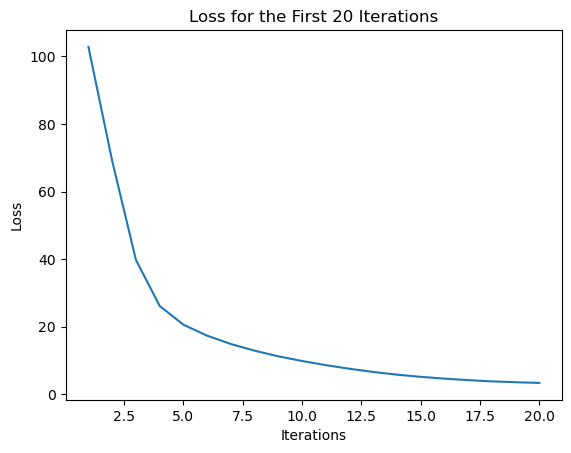

In [26]:
# Plotting the loss function for the first 20 iterations

plt.plot(range(1, 21), models[0].l[:20])
plt.title('Loss for the First 20 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### Plotting the Decision Boundary using two features

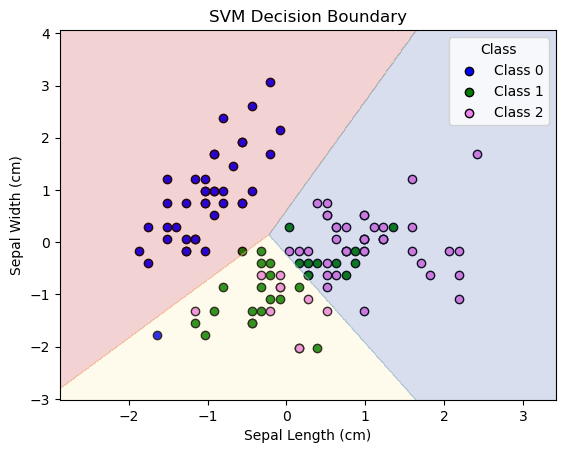

In [28]:
iris = load_iris()
X = iris.data[:, :2]
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Linear SVM model
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_scaled, y_train)

# Define a function to plot linear decision boundary
def svm_decision_boundary(X, y, model):
    
    colors = ['blue', 'green', 'violet']
    
    # Create a scatter plot of the training points
    for i, col in zip(np.unique(y), colors):
        plt.scatter(X[y == i, 0], X[y == i, 1], c=col, edgecolor='k', label=f'Class {i}')
        
    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    e, f = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[e.ravel(), f.ravel()])
    Z = Z.reshape(e.shape)
    
    plt.contourf(e, f, Z, alpha=0.2, cmap=plt.cm.RdYlBu)
    plt.xlabel('Sepal Length (cm)')
    plt.ylabel('Sepal Width (cm)')
    plt.title('SVM Decision Boundary')
    plt.legend(title='Class')
    plt.savefig('C:/Users/nagak/Downloads/Programming Assignment - 1/svm_Plot.png')  ### To save the plot
    plt.show()

svm_decision_boundary(X_train_scaled, y_train, svm_model)